<a href="https://colab.research.google.com/github/kl938/sysen5160/blob/main/SYSEN5160_HW4_kl938.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW4 - Sensitivity Analyses


This assignment will get you familiar with code in a state that you will often find it on an open-source repository or on the web in general. Such code is often not well commented and it is often not immediately clear which part serve which purpose. While working on your final project you will likely come cross messy code and/or data.
The repository we will be dealing with for this assignment is from the domain of `Building Science` and `Thermal Comfort`.

Thermal Comfort models are models that describe how people perceive and indoor/outdoor environment based on environmental and physiological variables, think "feels-like" temperature but much more sophisticated.
If you, as a researcher, would like to influence how comfortable people feel, you might want to know which of the input variables are the low-hanging fruits for you to change.
You might also be interested, in general, which ones are actually the important input variables, and which ones you might want to neglect.

This assignment will guide you through that process of sensitivity analysis.

# 0 - Reading & git
- Skim through `Höppe1999_Article_ThePhysiologicalEquivalentTemp.pdf` and familiarize yourself with the original PET model and its improved version from `Walther2019_The P.E.T. comfort index Questioning the model.pdf`
- Pull git repo: https://github.com/kastnerp/AREP.git (by Walther et al.)

In [ ]:
!rm -r AREP # comment out if AREP does not exist already (like the first time I ran this)
! git clone  https://github.com/kastnerp/AREP.git

Cloning into 'AREP'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 52 (delta 12), reused 16 (delta 8), pack-reused 28
Unpacking objects: 100% (52/52), done.


# 1 - Setting up model
- Import the `ET, resolution, Syst` functions from `PET_fsolve_code.py`
- Convince yourself that everything works

In [ ]:
import sys  
sys.path.insert(0, './AREP')
sys.path.append('.\AREP')

from PET_fsolve_code import *

- To get started, please report the PET for a for a `32 y` `female` with a body weight of `65 kg`, and a power output of `3 W/kg` during a running exercise in `5°C` ambient temperature and `3 m/s` wind velocity.

In [92]:
import math as math
import matplotlib.pyplot as plt
import numpy as np

# Input data #

# definition of constants
po = 1013.25  # [hPa]
rob = 1.06  # Blood density [kg/L]
cb = 3.64 * 1000.  # Blood specific heat [J/kg/k]
cair = 1.01 * 1000.  # Air specific heat  [J/kg/K]
emsk = 0.99  # Skin emissivity
emcl = 0.95  # Clothing emissivity
Lvap = 2.42 * 10. ** 6.  # Latent heat of evaporation [J/Kg]
sigm = 5.67 * 10. ** (-8.)  # Stefan-Boltzmann constant [W/(m2*K^(-4))]
eta = 0.  # Body efficiency

# Initialisation of Temperature vector with respectively: Tcore, Tskin, Tcl
T = [38, 40, 40]
eps = 10**(-6)  # numerical tolerance
# Dichotomy search interval (a=min / b=max)
Tmin = -40
Tmax = 60

# Input data for the PET
Ta = 5  # Air temperature in [oC]
Tmrt = 60  # Mean radiant temperature in [oC]
HR = 50  # Air relative humidity [%]
v = 3  # Wind velocity [m/s]
age = 32
sex = 2  # 1 for men and 2 for women
pos = 1
mbody = 65  # [kg]
ht = 1.80  # [m]
p = 1013.25  # [hPa]
M = 80  # [W] Metabolic activity level
icl = 0.5  # [clo] Clothing level




#################
# Your Code Starts Here (from https://github.com/eddes/AREP/blob/master/PET_fsolve_code.py)
#################
import numpy as np
import math as math
import scipy.optimize as optimize

# Skin and core temperatures set values
tc_set=36.6 # 36.8
tsk_set=34 # 33.7
tbody_set=0.1*tsk_set+0.9*tc_set # Calculation of the body temperature through a weighted average

# Skin blood flow calculation function:
def vasoC(tcore,tsk):
    #Set value signals
    sig_skin = tsk_set - tsk
    sig_core = tcore - tc_set
    if sig_core<0:
        # In this case, Tcore<Tc_set --> the blood flow is reduced
        sig_core=0.
    if sig_skin<0:
        # In this case, Tsk>Tsk_set --> the blood flow is increased
        sig_skin=0.
    # 6.3 L/m^2/h is the set value of the blood flow
    qmblood = (6.3 + 75. * sig_core) / (1. + 0.5 * sig_skin)
    # 90 L/m^2/h is the blood flow upper limit
    if qmblood>90:
        qmblood=90.
    # in the transient model, alpha is used to update tbody
    #alpha = 0.04177 + 0.74518 / (qmblood + 0.585417)
    alpha = 0.1
    return (qmblood,alpha)


# Sweating calculation function
def Suda(tbody,tsk):
    sig_body = tbody - tbody_set
    sig_skin = tsk - tsk_set
    if sig_body<0:
        #In this case, Tbody<Tbody_set --> The sweat flow is 0
        sig_body=0.
    if sig_skin<0:
        # In this case, Tsk<Tsk_set --> the sweat flow is reduced
        sig_skin=0.
    #qmsw = 170 * sig_body * math.exp((sig_skin) / 10.7)  # [g/m2/h] is the expression from Gagge's model
    qmsw = 304.94*10**(-3) * sig_body
    # 500 g/m^2/h is the upper sweat rate limit
    if qmsw > 500:
        qmsw = 500
    return (qmsw)

# Vectorial MEMI balance calculation function
def Syst(T, Ta, Tmrt, HR, v, age, sex, ht, mbody, pos, M, icl,mode):
    # Conversion of T vector in an array
    arr = np.ones((3,1))
    arr[0,0]=T[0] #Corresponds to T_core
    arr[1,0]=T[1] #Corresponds to T_skin
    arr[2,0]=T[2] #Corresponds to T_clothes
    T=arr
    enbal_vec = np.zeros((3,1)) #required for the vectorial expression of the balance

    # Area parameters of the body:
    Adu = 0.203 * mbody ** 0.425 * ht ** 0.725
    feff=0.725
    if pos == 1 or pos == 3:
        feff = 0.725
    if pos == 2:
        feff = 0.696
    # Calculation of the Burton surface increase coefficient, k = 0.31 for Hoeppe:
    fcl = 1 + (0.31 * icl) # Increase heat exchange surface depending on clothing level
    facl = (173.51 * icl - 2.36 - 100.76 * icl * icl + 19.28 * icl ** 3.0) / 100
    Aclo = Adu * facl + Adu * (fcl - 1.0)
    Aeffr = Adu * feff  # Effective radiative area depending on the position of the subject
    
	# Partial pressure of water in the air depending on relative humidity and air temperature:
    if mode: # mode=True is the calculation of the actual environment
        vpa = HR / 100.0 * 6.105 * math.exp(17.27 * Ta / (237.7 + Ta )) #[hPa]
    else: # mode=False means we are calculating the PET
        vpa= 12 # [hPa] vapour pressure of the standard environment

    # Convection coefficient depending on wind velocity and subject position
    hc = 0
    if pos == 1:
        hc = 2.67 + (6.5 *v**0.67)
    if pos == 2:
        hc = 2.26 + (7.42 *v**0.67)
    if pos == 3:
        hc = 8.6 * (v ** 0.513)
    # modification of hc with the total pressure
    hc = hc * (p / po) ** 0.55

    # Base metabolism for men and women in [W]
    metab_female=3.19*mbody**0.75*(1.0+0.004*(30.0-age)+0.018*(ht*100.0/mbody**(1.0/3.0)- 42.1))
    metab_male=3.45*mbody**0.75*(1.0+0.004*(30.0-age)+0.01*(ht*100.0/mbody**(1.0/3.0)-43.4))
    # Source term : metabolic activity
    if mode==True: # = actual environment
      metab = (M + metab_male)/Adu
      fec = (M + metab_female)/Adu
    else:# False=reference environment
        metab = (80 + metab_male)/Adu
        fec = (80 + metab_female)/Adu
	
    he = 0.0
    # Attribution of internal energy depending on the sex of the subject
    if sex == 1:
        he = metab
    elif sex == 2:
        he = fec
    h = he *(1.0 - eta) # [W/m2]

    # Respiratory energy losses
    # Expired air temperature calculation:
    texp = 0.47 * Ta + 21.0  # [degC]
    # Pulmonary flow rate
    dventpulm = he * 1.44 * 10.0**(-6.0)
    # Sensible heat energy loss:
    eres = cair * (Ta - texp) * dventpulm  # [W/m2]
    # Latent heat energy loss:
    vpexp = 6.11 * 10.0**(7.45 * texp / (235.0 + texp))
    erel = 0.623 * Lvap / p * (vpa-vpexp) * dventpulm  # [W/m2]
    ere = eres + erel  # [W/m2]

    # Clothed fraction of the body approximation
    rcl = icl / 6.45  # Conversion in m2.K/W
    y = 0
    if facl > 1.0:
        facl = 1.0
    if icl >= 2.0:
        y = 1.0
    if icl > 0.6 and icl < 2.0:
        y = (ht - 0.2)/ht
    if icl <= 0.6 and icl > 0.3:
        y = 0.5
    if icl <= 0.3 and icl > 0.0:
        y = 0.1
    # calculation of the closing radius depending on the clothing level (6.28 = 2* pi !)
    r2 = Adu * (fcl - 1.0 + facl) / (6.28 * ht * y)  # External radius
    r1 = facl * Adu /(6.28 * ht * y)  # Internal radius
    di = r2 - r1
    # Calculation of the equivalent thermal resistance of body tissues
    alpha = vasoC(T[0,0],T[1,0])[1]
    tbody = alpha * T[1,0] + (1 - alpha) * T[0,0]
    htcl = (6.28 * ht * y * di)/(rcl * math.log(r2/r1)*Aclo)  # [W/(m2.K)]
    # Calculation of sweat losses
    qmsw = Suda(tbody,T[1,0])
    # Lvap/1000 = 2400 000[J/kg] divided by 1000 = [J/g] // qwsw/3600 for [g/m2/h] to [g/m2/s]
    esw = Lvap/1000* qmsw/3600  # [W/m2]
    # Saturation vapor pressure at temperature Tsk
    Pvsk = 6.105*math.exp((17.27 * (T[1,0]+273.15) - 4717.03)/ (237.7 + T[1,0])) # [hPa]
	# Calculation of vapour transfer
    Lw = 16.7*10 **(-1)  # [K/hPa] Lewis factor
    he_diff = hc * Lw # diffusion coefficient of air layer
    fecl=1/(1+0.92*hc*rcl) # Burton efficiency factor
    emax = he_diff * fecl * (Pvsk - vpa) # maximum diffusion at skin surface
    w = esw / emax  # skin wettedness
    if w > 1:
        w=1
        delta = esw-emax
        if delta < 0:
            esw=emax
    if esw < 0:
        esw=0
    i_m=0.38 # Woodcock's ratio
    R_ecl=(1/(fcl*hc) + rcl)/(Lw*i_m) # clothing vapour transfer resistance after Woodcock's method
    #R_ecl=0.79*1e7 # Hoeppe's method for E_diff
    ediff = (1 - w)*(Pvsk - vpa)/R_ecl  # diffusion heat transfer
    evap = -(ediff + esw)  # [W/m2]

    # Radiation losses
    # For bare skin area:
    rbare = Aeffr*(1.0 - facl) * emsk * sigm * ((Tmrt + 273.15)**(4.0) - (T[1,0] + 273.15)**(4.0))/Adu
    # For dressed area:
    rclo = feff * Aclo * emcl * sigm * ((Tmrt + 273.15)**(4.0) - (T[2,0] + 273.15)**(4.0))/Adu
    rsum = rclo+rbare

    # Convection losses #
    cbare = hc * (Ta - T[1,0]) * Adu * (1.0 - facl)/Adu  # [w/m^2]
    cclo = hc * (Ta - T[2,0]) * Aclo/Adu  # [W/m^2]
    csum = cclo+cbare

    # Balance equations of the 3-nodes model
    enbal_vec[0,0] = h + ere - (vasoC(T[0,0],T[1,0])[0]/3600*cb+5.28)*(T[0,0]-T[1,0]) # Core balance [W/m^2]
    enbal_vec[1,0] = rbare + cbare + evap + (vasoC(T[0,0],T[1,0])[0]/3600*cb+5.28)*(T[0,0]-T[1,0]) - htcl*(T[1,0]-T[2,0])  # Skin balance [W/m^2]
    enbal_vec[2,0] = cclo + rclo + htcl*(T[1,0]-T[2,0]) # Clothes balance [W/m^2]
    enbal_scal = h + ere + rsum + csum +evap

	#returning either the calculated core,skin,clo temperatures or the PET
    if mode:
		# if we solve for the system we need to return 3 temperatures 
        return [enbal_vec[0,0],enbal_vec[1,0],enbal_vec[2,0]]
    else:
		# solving for the PET requires the scalar balance only
        return enbal_scal

# Solving the 3 equation non-linear system
def resolution(Ta, Tmrt, HR, v, age, sex, ht, mbody, pos, M, icl, Tx):
    Tn = optimize.fsolve(Syst,Tx ,args=(Ta, Tmrt, HR, v, age, sex, ht, mbody, pos, M, icl, True))
    return (Tn, 1)

# PET calculation with dichotomy method 
def PET (age, sex, ht, mbody, pos, M, icl, Tstable,a,b,eps):
    # Definition of a function with the input variables of the PET reference situation
    def f(Tx):
        return Syst(Tstable, Tx, Tx, 50, 0.1, age, sex, ht, mbody, pos, M, 0.9,False)
    Ti = Tmin # Start of the search interval
    Tf = Tmax # End 	of the search interval
    pet = 0
    while Tf-Ti>eps: # Dichotomy loop
        if f(Ti)*f(pet)<0:
            Tf = pet
        else:
            Ti = pet
        pet = (Ti + Tf) / 2.0
    return pet

# Results 
Tstable = resolution(Ta,Tmrt,HR,v,age,sex,ht,mbody,pos,M,icl,T)[0]
print("Nodes temperature [T_core, T_skin, T_clo]",Tstable)
print('Thermal Balance', Syst(Tstable, Ta, Tmrt, HR, v, age, sex, ht, mbody, pos, M, icl,True)[0])
print('PET:', round(PET(age, sex, ht, mbody, pos, M, icl, Tstable, Tmin, Tmax, eps),2))

#################
# Your Code Ends Here
#################






Nodes temperature [T_core, T_skin, T_clo] [30.87342392 17.76493567 17.59526801]
Thermal Balance -2.1433095298561966e-09
PET: 11.26


# 2 - Global Sensitivity Analysis

## Generating samples

We will start with a Global Sensitivity Analysis (Global SA). For this we will use the Python package `SALib` (https://salib.readthedocs.io/en/latest/).
First, we need to create a large sample of our input space that we then can analyse.

- Please install SALib and familiarize yourself which how to set up a model: https://salib.readthedocs.io/en/latest/getting-started.html#installing-salib.
- Set up the problem for our `PET` class in `PET_fsolve_code`. For the problems you are interested in both physiological and environmental input variables (input data for PET), do not include constants or initialization vectors. Assume reasonable ranges for your input variables, e.g. for relative humidity (5-95%).
- Please use a `Saltelli` sample for your problem setup and calculate second-order indices (https://salib.readthedocs.io/en/latest/api/SALib.sample.html?highlight=saltelli#SALib.sample.saltelli.sample).
- Start with `n = 200` and increase the number of samples after everything works.
- Convince yourself the matrix has the correct shape (samples = number of rows; number of input variables = columns) with `yourmatrix.shape` (numpy extension).

In [93]:
# 4 - Global sensitivity analysis
#!pip install SALib
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.sample import morris as ms
from SALib.analyze import morris as ma
from SALib.plotting import morris as mp
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Taken from codebase 

# # definition of constants
# po = 1013.25  # [hPa]
# rob = 1.06  # Blood density [kg/L]
# cb = 3.64 * 1000.  # Blood specific heat [J/kg/k]
# cair = 1.01 * 1000.  # Air specific heat  [J/kg/K]
# emsk = 0.99  # Skin emissivity
# emcl = 0.95  # Clothing emissivity
# Lvap = 2.42 * 10. ** 6.  # Latent heat of evaporation [J/Kg]
# sigm = 5.67 * 10. ** (-8.)  # Stefan-Boltzmann constant [W/(m2*K^(-4))]
# eta = 0.  # Body efficiency

# # Initialisation of Temperature vector with respectively: Tcore, Tskin, Tcl
# T = [38, 40, 40]
# eps = 10**(-6)  # numerical tolerance
# # Dichotomy search interval (a=min / b=max)
# Tmin = -40
# Tmax = 60

# # Input data for the PET
# Ta = 5  # Air temperature in [oC]
# Tmrt = 60  # Mean radiant temperature in [oC]
# HR = 50  # Air relative humidity [%]
# v = 5  # Wind velocity [m/s]
# age = 32
# sex = 2  # 1 for men and 2 for women
# pos = 1
# mbody = 65  # [kg]
# ht = 1.80  # [m]
# p = 1013.25  # [hPa]
# M = 80  # [W] Metabolic activity level
# icl = 0.5  # [clo] Clothing level

# # Results
# Tstable = resolution(Ta, Tmrt, HR, v, age, sex, ht, mbody, pos, M, icl, T)[0]
# print("Nodes temperature [T_core, T_skin, T_clo]", Tstable)
# print('Thermal Balance', Syst(Tstable, Ta, Tmrt, HR, v, age, sex, ht, mbody, pos, M, icl, True)[0])
# print('PET:', round(PET(age, sex, ht, mbody, pos, M, icl, Tstable, Tmin, Tmax, eps), 2))


# Define the model inputs
problem = {
    'num_vars': 11,
    'names': ['Ta', 'Tmrt', 'HR', 'v', 'age', 'sex', 'ht', 'mbody', 'pos', 'M', 'icl'],
    'bounds': [
        [-30, 40],
        [-30, 40],
        [1, 100],
        [0.1, 10],
        [15, 90],
        [1, 2],
        [1.40, 2.10],
        [50, 120],
        [1, 3],
        [50, 300],
        [0.1, 2]
    ],
    # I don't want to group any of these variables together
    # 'groups': None
}

print(problem)

# Generate samples
n = 500
param_values = saltelli.sample(problem, n, calc_second_order=True)

print(type(param_values))

print(param_values.shape)




{'num_vars': 11, 'names': ['Ta', 'Tmrt', 'HR', 'v', 'age', 'sex', 'ht', 'mbody', 'pos', 'M', 'icl'], 'bounds': [[-30, 40], [-30, 40], [1, 100], [0.1, 10], [15, 90], [1, 2], [1.4, 2.1], [50, 120], [1, 3], [50, 300], [0.1, 2]]}
<class 'numpy.ndarray'>
(12000, 11)


/usr/local/lib/python3.7/dist-packages/SALib/sample/saltelli.py:94: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (500) is equal to `2^n`.
        
  warnings.warn(msg)


## Calculating the objective function

Now it is time to use the samples to calculate the objective function. Because of the nature of the code, it is not straight-forward to vectorize it. Hence let's take care of it in a loop.

- Initialize your results vector `Y` with `np.zeros()` and pass the appropriate dimensions from before.
- In a loop, evaluate the PET objective function `Y[i]` by taking the input variables from the respective rows and columns from the sample matrix, e.g. `age = param_values[i, 4]` if `age` is your 4th column. For categorical values, feel free to use a rounding function.
- You should now have an one-dimensional vector that holds your function evaluations.

In [94]:
#################
# Your Code Starts Here
# from https://salib.readthedocs.io/en/latest/getting-started.html#installing-salib
#################
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np

# Define the model inputs
# 'problem' from above

# Generate samples
# param_values from above
#param_values = saltelli.sample(problem, 1024)

# Run model (example)
Y = Ishigami.evaluate(param_values)
# np.zeros gave an error, so kept the Ishigami from the source linked at the top of this section.

# Perform analysis
Si = sobol.analyze(problem, Y, print_to_console=True)

# Print the first-order sensitivity indices
print(Si['S1'])


#################
# Your Code Ends Here
#################

                 ST       ST_conf
Ta     9.365756e-01  2.110341e-01
Tmrt   9.409643e-13  1.619604e-13
HR     6.508082e-01  1.142331e-01
v      0.000000e+00  0.000000e+00
age    0.000000e+00  0.000000e+00
sex    0.000000e+00  0.000000e+00
ht     0.000000e+00  0.000000e+00
mbody  0.000000e+00  0.000000e+00
pos    0.000000e+00  0.000000e+00
M      0.000000e+00  0.000000e+00
icl    0.000000e+00  0.000000e+00
                 S1       S1_conf
Ta     3.687241e-01  1.464841e-01
Tmrt  -2.165120e-09  9.541793e-08
HR     5.094550e-02  1.566751e-01
v      0.000000e+00  0.000000e+00
age    0.000000e+00  0.000000e+00
sex    0.000000e+00  0.000000e+00
ht     0.000000e+00  0.000000e+00
mbody  0.000000e+00  0.000000e+00
pos    0.000000e+00  0.000000e+00
M      0.000000e+00  0.000000e+00
icl    0.000000e+00  0.000000e+00
                         S2       S2_conf
(Ta, Tmrt)    -3.024923e-03  8.933243e-02
(Ta, HR)       6.691028e-01  2.936606e-01
(Ta, v)       -3.025037e-03  8.933237e-02
(Ta, age)     -3

## Analyzing the problem

- Let's analyze the problem with Sobol's method via `Si = sobol.analyze(your_problem, Y, print_to_console=True)`
- Feel free to use the plotting function to visualize your first-order sensitivity indices.

,ST,ST_conf,S1,S1_conf
Ta,9.365756e-01,2.144149e-01,3.687241e-01,1.448345e-01
Tmrt,9.409643e-13,1.685548e-13,-2.165120e-09,1.360875e-07
HR,6.508082e-01,9.229080e-02,5.094550e-02,1.539035e-01
v,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
age,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
sex,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
ht,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
mbody,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
pos,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
M,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


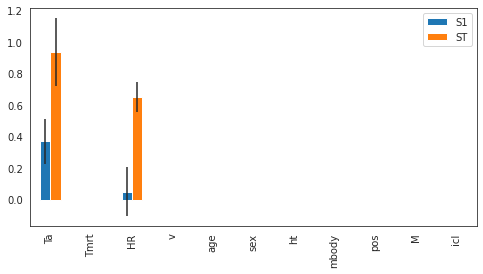

In [95]:
import seaborn as sns

def table_and_barplot(Si):

    Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
    Si_df = pd.DataFrame(Si_filter, index=problem['names'])

    display(Si_df)

    sns.set_style('white')
    fig, ax = plt.subplots(1)

    indices = Si_df[['S1','ST']]
    err = Si_df[['S1_conf','ST_conf']]

    indices.plot.bar(yerr=err.values.T,ax=ax)
    fig.set_size_inches(8,4)

    plt.show()


Si = sobol.analyze(problem, Y,calc_second_order=True, print_to_console=False)
table_and_barplot(Si)

- Can you tell which input variables seem more dominant than others? Please report how you would interpret $S_1$ and $S_T$. Please answer in a couple of sentences.

Let's create a more sophisticated visualization that shows the second-order interactions as well. Please use the `plot_sobol_indices()` function to create a radial plot.

[0.         0.57119866 1.14239733 1.71359599 2.28479466 2.85599332
 3.42719199 3.99839065 4.56958931 5.14078798 5.71198664 6.28318531]
['Ta', 'Tmrt', 'HR', 'v', 'age', 'sex', 'ht', 'mbody', 'pos', 'M', 'icl']


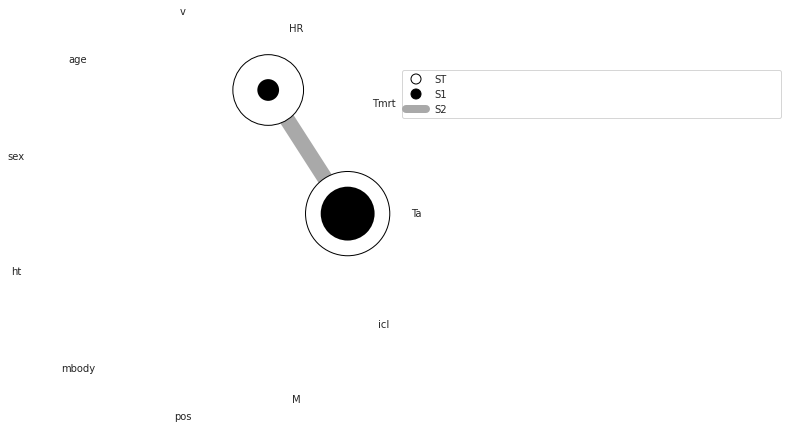

In [96]:
#!pip install helper_functions
#################
# Provided helper_functions Code (via Canvas) Starts Here
#################
import itertools
from math import pi
import seaborn as sns
sns.set_style('whitegrid')
from math import pi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def normalize(x, xmin, xmax):
    return (x-xmin)/(xmax-xmin)


def plot_circles(ax, locs, names, max_s, stats, smax, smin, fc, ec, lw,
                 zorder):
    s = np.asarray([stats[name] for name in names])
    s = 0.01 + max_s * np.sqrt(normalize(s, smin, smax))

    fill = True
    for loc, name, si in zip(locs, names, s):
        if fc=='w':
            fill=False
        else:
            ec='none'

        x = np.cos(loc)
        y = np.sin(loc)

        circle = plt.Circle((x,y), radius=si, ec=ec, fc=fc, transform=ax.transData._b,
                            zorder=zorder, lw=lw, fill=True)
        ax.add_artist(circle)


def filter(sobol_indices, names, locs, criterion, threshold):
    if criterion in ['ST', 'S1', 'S2']:
        data = sobol_indices[criterion]
        data = np.abs(data)
        data = data.flatten() # flatten in case of S2
        # TODO:: remove nans

        filtered = ([(name, locs[i]) for i, name in enumerate(names) if
                     data[i]>threshold])
        filtered_names, filtered_locs = zip(*filtered)
    elif criterion in ['ST_conf', 'S1_conf', 'S2_conf']:
        raise NotImplementedError
    else:
        raise ValueError('unknown value for criterion')

    return filtered_names, filtered_locs


def plot_sobol_indices(problem, sobol_indices, criterion='ST', threshold=0.01):
    '''plot sobol indices on a radial plot

    Parameters
    ----------
    sobol_indices : dict
                    the return from SAlib
    criterion : {'ST', 'S1', 'S2', 'ST_conf', 'S1_conf', 'S2_conf'}, optional
    threshold : float
                only visualize variables with criterion larger than cutoff

    '''
    max_linewidth_s2 = 15#25*1.8
    max_s_radius = 0.3

    # prepare data
    # use the absolute values of all the indices
    #sobol_indices = {key:np.abs(stats) for key, stats in sobol_indices.items()}

    # dataframe with ST and S1
    sobol_stats = {key:sobol_indices[key] for key in ['ST', 'S1']}
    sobol_stats = pd.DataFrame(sobol_stats, index=problem['names'])

    smax = sobol_stats.max().max()
    smin = sobol_stats.min().min()

    # dataframe with s2
    s2 = pd.DataFrame(sobol_indices['S2'], index=problem['names'],
                      columns=problem['names'])
    s2[s2<0.0]=0. #Set negative values to 0 (artifact from small sample sizes)
    s2max = s2.max().max()
    s2min = s2.min().min()

    names = problem['names']
    n = len(names)
   
    ticklocs = np.linspace(0, 2*pi, n+1)
    print(ticklocs)
    locs = ticklocs[0:-1]


    filtered_names, filtered_locs = filter(sobol_indices, names, locs,
                                           criterion, threshold)

    # setup figure
    fig = plt.figure()
    ax = fig.add_subplot(111, polar=True)
    ax.grid(False)
    ax.spines['polar'].set_visible(False)
   
    ax.set_xticks(ticklocs[0:len(names)])

    print(names)
    ax.set_xticklabels(names)
    ax.set_yticklabels([])
    
    ax.set_ylim(top=1.4)
    legend(ax)

    # plot ST
    plot_circles(ax, filtered_locs, filtered_names, max_s_radius,
                 sobol_stats['ST'], smax, smin, 'w', 'k', 1, 9)

    # plot S1
    plot_circles(ax, filtered_locs, filtered_names, max_s_radius,
                 sobol_stats['S1'], smax, smin, 'k', 'k', 1, 10)

    # plot S2
    for name1, name2 in itertools.combinations(zip(filtered_names, filtered_locs), 2):
        name1, loc1 = name1
        name2, loc2 = name2

        weight = s2.loc[name1, name2]
        lw = 0.5+max_linewidth_s2*normalize(weight, s2min, s2max)
        ax.plot([loc1, loc2], [1,1], c='darkgray', lw=lw, zorder=1)

    return fig


from matplotlib.legend_handler import HandlerPatch
class HandlerCircle(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
        p = plt.Circle(xy=center, radius=orig_handle.radius)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]

def legend(ax):
    some_identifiers = [plt.Circle((0,0), radius=5, color='k', fill=False, lw=1),
                        plt.Circle((0,0), radius=5, color='k', fill=True),
                        plt.Line2D([0,0.5], [0,0.5], lw=8, color='darkgray')]
    ax.legend(some_identifiers, ['ST', 'S1', 'S2'],
              loc=(1,0.75), borderaxespad=0.1, mode='expand',
              handler_map={plt.Circle: HandlerCircle()})




def plot_2D(X, Y, Z, X_label, Y_label):

    plt.rcParams.update({'font.size': 12})
    
    Z_min = int(Z.min())
    Z_max = int(Z.max())

    divisions = int((Z_max-Z_min)/10)

    fig, ax = plt.subplots(1, 1, figsize=(12.5, 10))
    plot = ax.pcolor(X, Y, Z, cmap=cm.get_cmap('Spectral_r', 256), vmin=Z_min, vmax=Z_max)
    levels = [i for i in range(Z_min,Z_max,divisions)]


    con = ax.contour(X, Y, Z, levels, colors='k')
    plt.clabel(con, inline=1, fontsize=12, fmt='%d')

    ax.set_ylabel(Y_label)
    ax.set_xlabel(X_label)
    bar = fig.colorbar(plot, ax=ax)
    bar.set_label('PET [°C]')
    plt.show()

#################
# Provided helper_functions Code (via Canvas) Ends Here
#################

from helper_functions import *


fig = plot_sobol_indices(problem, Si, criterion='ST', threshold=0.0000005)
fig.set_size_inches(7,7)
plt.show()

# Save figure
name = "Radial_plot_S1_S2_ST"
fig.savefig(name + '.pdf', bbox_inches='tight', pad_inches=0.0)
fig.savefig(name + '.png', bbox_inches='tight', pad_inches=0.0, dpi = 600)


- Which variables seem most dominant? Which ones have second-order interactions with each other? Does this make sense to you? Please answer in a couple of sentences.

**It looks like HR (air relative humidity) and Ta (air temperature) are the most dominant variables. Icl (clothing level) and v (wind velocity) are also variables that impact PET, but seem to be second-order. Ta makes sense as being the dominant variable, because clothing and wind don't matter as much if the air temperature is warm. I would have thought that wind velocity would be more dominant than humidity, just off personal anecdotal experience. However, after looking it up, high humidity in cold or hot weather usually means precipitation is inbound or just occured, which would impact PET.**

# 3 - Two-at-a-time sensitivity analysis *(Bonus challenge)*

You have now completed the Global SA and you know the dominant input variables and their interactions. However, you don't know for sure about the direction of the interaction, e.g. `v`, the wind velocity seems to be very dominant and there is a second-order interaction with clothing. This might seem obvious in our case since the models predicts and "feels-like" temperature. What if you were less familiar with the objective function? In that case you'd have to dig a little deeper.

I prefer running Global SAs first and Two-at-a-time SAs later. Let's plot the interaction in two dimension. You can think about this as 'cutting' through the hyper volume of the objective function.

1. Define an integer `quality` and set it to some value, say 30.
2. Define a function `pet_matrix()` that takes `quality` as an input, and that outputs three matrices, the `pet` and two input vectors which we will define below.
3. Pick two input variables of the PET model and define a meshgrid via `np.meshgrid()` and `np.linspace()`. Use `quality` to control the resolution of the meshgrid.
4. Initialize an empty matrix that you can fill with your function evaluations. It should have appropriate dimensions based on your `quality` parameter.
5. Loop over both dimensions of the meshgrid and calculate the PET based on your chosen input variables.




## Calculate PET matrix

In [ ]:
import numpy as np

qual = 30

#################
# Your Code Starts Here
#################




def pet_matrix(qual):   
    
    pass



#################
# Your Code Ends Here
#################

### Plotting

Once done, please use the plotting function below to plot this two-dimensional interaction of your chosen input variables.

Plot it like so:


```
X = input_1
Y = input_2
Z = pet

X_label = 'Label 1'
Y_label = 'Label 2'

plot_2D(X, Y, Z, X_label, Y_label)
```

In [ ]:
from helper_functions import *


X = v_in
Y = icl_in
Z = pet

X_label = 'Wind velocity [m/s]'
Y_label = 'Clothing [-]'

plot_2D(X, Y, Z, X_label, Y_label)

NameError: ignored

Based on this plot, does the interaction between the two variables that you plotted make sense? Please answer in a couple of sentences.

---
**I did not attempt the coding portion for this Bonus Challenge. However, looking at the figure provided in the base Canvas code, I can try to answer this part. Yes, this makes sense because you can look at the plot as 4 quadrants. The top left quadrant is the warmest, because there is no wind and lots of clothing. The bottom right quadrant is the coldest, because there is a lot of wind and little to no clothing. The plot shows that the wind velocity has a greater impact on PET than clothing.**

---

